In [1]:
import pandas as pd
import numpy as np
import missing_values_module as mvm

In [2]:
test_df = mvm.create_test_df(nans = False)
test_df = test_df.drop("xcat", axis = 1)
test_df.x4 = test_df.x4.astype(float)

In [3]:
class OutputCorrelationFilter():
    
    def __init__(
                self, n_features = False, 
                share_features = False,  
                max_acceptable_correlation = False,
                corr_metrics = "pearson"
                ):
        
        if (np.array([n_features, share_features, max_acceptable_correlation]) != False).sum() > 1:
            raise ValueError("Please, predefine ONE OF: acceptable correlation, share of features or number of features")
        if (np.array([n_features, share_features, max_acceptable_correlation]) != False).sum() == 0:
            raise ValueError("Please, choose either acceptable correlation, share of features or number of features")
            
        self.n_features = n_features
        self.share_features = share_features
        self.corr_metrics = corr_metrics
        self.max_acceptable_correlation = max_acceptable_correlation

        
    def fit(self, X, y):
        
        if self.share_features != False:
            self.n_features = round(len(X.columns) * share_features)
        
        if self.n_features == 0:
            self.n_features = 1
        
        corrs = X.apply( lambda column: column.corr(y, method = self.corr_metrics) )
        
        if self.max_acceptable_correlation != False:
            self.n_features = (corrs <= self.max_acceptable_correlation).sum()
            
        self.desired_names = corrs.sort_values(ascending = False).index[:self.n_features].tolist()
        
        return self
    
    def transform(self, X, y= None):
        
        return X[self.desired_names]

    
class MutualCorrelationFilter():
    
    def __init__(
                self, n_features = False, 
                share_features = False, 
                max_acceptable_correlation = False,
                corr_metrics = "pearson"
                ):
        
        
        if (np.array([n_features, share_features, max_acceptable_correlation]) != False).sum() > 1:
            raise ValueError("Please, predefine ONE OF: acceptable correlation, share of features or number of features")
        if (np.array([n_features, share_features, max_acceptable_correlation]) != False).sum() == 0:
            raise ValueError("Please, choose either acceptable correlation, share of features or number of features")
            
        self.n_features = n_features
        self.share_features = share_features
        self.corr_metrics = corr_metrics
        self.max_acceptable_correlation = max_acceptable_correlation
        
    def fit(self, X, y = None):
        
        if self.share_features != False:
            self.n_features = round(len(X.columns) * self.share_features)
        
        if (self.n_features == 0)&(self.share_features != False):
            self.n_features = 1
        
        current_df = X.copy()
        while len(current_df.columns) > self.n_features:
            current_corr = current_df.corr(method = self.corr_metrics).unstack().sort_values(ascending = False)
            for i in range(len(current_corr)):
                column_names = current_corr.index[i]
                corr_value = current_corr.iloc[i]
                if column_names[0] != column_names[1]:
                    most_correlated_column = column_names[0]
                    break
                    
            if len(current_df.columns) == 1:
                break
                
            if corr_value <= self.max_acceptable_correlation:
                break
                
            current_df.drop(most_correlated_column, axis = 1, inplace = True)
            
        self.desired_names = current_df.columns.tolist()
        
        return self
    
    def transform(self, X, y= None):
        
        return X[self.desired_names]
        
class VIFFilter():
    
    def __init__(self, acceptable_vif = [5, 10]):
        
        self.acceptable_vif = acceptable_vif
        
    def fit(self, X, y = None):
        vifs = pd.Series(np.linalg.inv(X.corr().to_numpy()).diagonal(), 
                 index=X.columns, 
                 name='VIF')
        self.desired_names = vifs[(vifs <= self.acceptable_vif[0]) | (vifs >= self.acceptable_vif[1])].index.tolist()
        return self
    
    def transform(self, X, y = None):
        
        return X[self.desired_names]

In [148]:
obj = OutputCorrelationFilter(n_features = 2)
obj.fit(test_df, test_df.target)
obj.transform(test_df)

,target,x2
0,1,0.692927
1,0,-1.445092
2,1,-0.149126
3,0,0.278142
4,1,0.490160
...,...,...
9995,1,0.208233
9996,0,-1.588247
9997,0,2.014633
9998,0,-0.126842


In [152]:
obj = OutputCorrelationFilter(max_acceptable_correlation = 0.02)
obj.fit(test_df, test_df.target)
obj.transform(test_df)

,target,x2
0,1,0.692927
1,0,-1.445092
2,1,-0.149126
3,0,0.278142
4,1,0.490160
...,...,...
9995,1,0.208233
9996,0,-1.588247
9997,0,2.014633
9998,0,-0.126842


In [117]:
obj = MutualCorrelationFilter(share_features = 0.3, corr_metrics = "spearman")
obj.fit(test_df, test_df.target)
obj.transform(test_df)

,target
0,1
1,0
2,1
3,0
4,1
...,...
9995,1
9996,0
9997,0
9998,0


In [163]:
obj = MutualCorrelationFilter(max_acceptable_correlation = 0.05)
obj.fit(test_df, test_df.target)
obj.transform(test_df)

,x1,x2,x4,target
0,-2.460549,0.692927,1.224748,1
1,-0.754147,-1.445092,1.630030,0
2,-0.116082,-0.149126,-0.486066,1
3,-0.441963,0.278142,1.439447,0
4,1.292590,0.490160,2.011197,1
...,...,...,...,...
9995,0.803184,0.208233,1.188670,1
9996,-1.182124,-1.588247,-0.360197,0
9997,-1.341049,2.014633,0.153415,0
9998,0.132045,-0.126842,-0.066586,0


In [173]:
obj = VIFFilter()
obj.fit(test_df, test_df.target)
obj.transform(test_df)

,x1,x2,x4,target
0,-2.460549,0.692927,1.224748,1
1,-0.754147,-1.445092,1.630030,0
2,-0.116082,-0.149126,-0.486066,1
3,-0.441963,0.278142,1.439447,0
4,1.292590,0.490160,2.011197,1
...,...,...,...,...
9995,0.803184,0.208233,1.188670,1
9996,-1.182124,-1.588247,-0.360197,0
9997,-1.341049,2.014633,0.153415,0
9998,0.132045,-0.126842,-0.066586,0


# Алгоритм Брона-Кербоша
Описан в [статье](https://habr.com/ru/company/akbarsdigital/blog/592493/), код [отсюда](https://github.com/dmitryokhotnikov/Habr/blob/main/Article_experiments_code.ipynb). Вообще не очень предназначен, чтобы сокращать количество факторов до желаемого, зато должен устранять мультиколлинеарность. Предлагаю использовать как отдельный шаг, не вместе с другими фильтрами.

In [5]:
import cliques_filter_module as cliques 
import matplotlib.pyplot as plt

In [23]:
test_df["x5"] = np.random.random(10000)
test_df["x6"] = np.random.random(10000)
test_df["x7"] = np.random.random(10000)
test_df["x8"] = test_df["x7"] * 2
test_df["x9"] = test_df["x7"] * 0.5 + np.random.random(10000)


In [39]:
# Поиск максимальных клик, https://habr.com/ru/company/akbarsdigital/blog/592493/
qlq_list, G = cliques.get_noncollinear_fts(
    test_df.drop(columns=["target"]), test_df.target, trsh=0.65, mode="max", verbose=True)

=> mutual info calculation...
Task completed in: 0:00:00.492120

=> corr_matrix calculation...
Task completed in: 0:00:00.003050

=> graph assembling...
Task completed in: 0:00:00.002139

=> qliques search...
4 qliques are found:

7    4
dtype: int64
Task completed in: 0:00:00.001510

=> best cliques search...
Search best clique for dim = 7
Task completed in: 0:00:00.000124

All tasks completed in: 0:00:00.499329


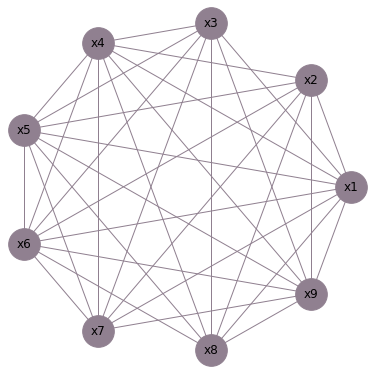

In [31]:
# Отрисовка графа для модельной задачи
plt.figure(figsize=(5, 5))
cliques.nx.draw_circular(G, with_labels=1, node_color='#908090',
                 edge_color='#908090', node_size=1000)

In [40]:
qlq_list

{7: (['x6', 'x9', 'x5', 'x4', 'x1', 'x2', 'x8'], 0.025485905801091224)}

In [34]:
qlq_list[7]

(['x6', 'x9', 'x5', 'x4', 'x1', 'x2', 'x8'], 0.025485905801091224)

In [38]:
qlq_list[list(qlq_list)[0]][0]

['x6', 'x9', 'x5', 'x4', 'x1', 'x2', 'x8']

In [44]:
class CliquesFilter():
    
    def __init__(self, trsh = 0.65):
        self.trsh = 0.65
        
    def fit(self, X, y):
        qlq_list, G = cliques.get_noncollinear_fts(
                                                    X, y, trsh=0.65, mode="all", verbose=False
                                                    )
        self.desired_names = qlq_list[list(qlq_list)[0]][0]
        
    def transform(self, X, y = None):
        
        return X[self.desired_names]


In [45]:
obj = CliquesFilter()
obj.fit(test_df, test_df.target)
obj.transform(test_df)

All tasks completed in: 0:00:00.608675


,x6,x9,target,x5,x4,x1,x2,x8
0,0.827652,0.720231,1,0.594958,1.352554,-0.003775,-0.000116,0.047363
1,0.253469,0.601477,1,0.511717,-1.779669,-0.806570,-0.253870,0.241484
2,0.676013,1.024381,1,0.902406,-1.294007,-0.337509,-0.435475,0.231984
3,0.952517,0.411006,0,0.910913,0.861897,0.078137,0.158400,0.976912
4,0.810537,1.078262,0,0.703518,-1.410863,-0.359707,-0.291841,0.331148
...,...,...,...,...,...,...,...,...
9995,0.732271,0.710988,0,0.165697,0.691797,0.321633,0.478155,1.508418
9996,0.702199,0.964617,1,0.026865,0.943825,-0.481762,-0.233111,0.037879
9997,0.293843,0.834051,1,0.055607,0.200740,1.949620,1.009004,1.876330
9998,0.124395,0.806973,1,0.806297,1.972402,-1.054671,-1.011123,1.676974
